# A Python tutorial on validating gVirtualXRay:
## Analytic simulation vs. Monte Carlo simulation
### With a realistic beam spectrum and taking into account the energy response of the detector
#### Authors: T. Wen, A. Sujar and F. P. Vidal

**Purpose:** In this notebook, we aim to demonstrate that gVirtualXRay is able to generate analytic simulations on GPU comparable to real images from the [Visible Human Project (VHP)](https://www.nlm.nih.gov/research/visible/visible_human.html). We take into account i) a realistic beam spectrum and ii) the energy response of the detector.

**Material and Methods:** <!--We simulate an image with gVirtualXRay and compare it with a ground truth image. For this purpose, we use [Gate],(http://www.opengatecollaboration.org/) a wrapper for CERN's state-of-the-art Monte Caro simulation tool: [Geant4](https://geant4.web.cern.ch/).-->

<!-- In our simulation the source-to-object distance (SOD) is 1000mm, and the source-to-detector distance (SDD) is 1125mm. The beam spectrum is polychromatic and the energy response of the detector is considered.
 -->
<!-- ![Geometric parameters](doc/setup.png)
 -->
<!--The sample is made of a 70x70x15mm box of water, in which 5 columns of 3 spheres of different radii (2, 3.5, and 5mm) have been inserted. A given material is associated to the spheres of each column (bone (cortical), blood (whole), brain (grey/white matter), breast tissue, and adipose tissue). The columns are ordered in decreasing density.--> We use the definitions of tissue substitutes provided in the [ICRU Report 44](https://www.icru.org/report/tissue-substitutes-in-radiation-dosimetry-and-measurement-report-44/) by the [International Commission on Radiation Units and Measurements](https://www.icru.org/). <!--The material composition is available at [https://physics.nist.gov/PhysRefData/XrayMassCoef/tab2.html](https://physics.nist.gov/PhysRefData/XrayMassCoef/tab2.html).-->

![Sample composition](plots/VHP_model.png)

**Results:** The [mean absolute percentage error (MAPE)](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error), also known as mean absolute percentage deviation (MAPD), between the two simulated images is **MAPE ????%**. The **[zero-mean normalised cross-correlation](https://en.wikipedia.org/wiki/Cross-correlation#Zero-normalized_cross-correlation_(ZNCC)) is ????%**. 
The **[Structural Similarity Index (SSIM)](https://en.wikipedia.org/wiki/Structural_similarity) is 0.????**. 
As MAPE is low (close to 0), SSIM is 0.???, and ZNCC is high (close to 100%), we can conclude that X-ray images simulated with gVirtualXRay on GPU in milliseconds are comparable to Monte Carlo simulations ran on supercomputers for days.

## Import packages

In [3]:
%matplotlib inline

import os # Locate files

import math
import numpy as np # Who does not use Numpy?
import pandas as pd # Load/Write CSV files

import matplotlib
# old_backend =  matplotlib.get_backend() 
# matplotlib.use("Agg")  # Prevent showing stuff

from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt # Plotting
from matplotlib.colors import LogNorm # Look up table
import matplotlib.colors as mcolors

font = {'family' : 'serif',
        #'weight' : 'bold',
         'size'   : 22
       }
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True)

from scipy.stats import pearsonr # Compute the correlatio coefficient

from skimage.util import compare_images # Checkboard comparison between two images
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_absolute_percentage_error as mape
from skimage.metrics import structural_similarity as ssim

from tifffile import imread, imsave # Load/Write TIFF files

import viewscad # Use OpenSCAD to create STL files

# import pyvista as pv # 3D visualisation
# from pyvista import themes

# import cma # Optimise the parameters of the noise model

import k3d
import random
import base64
import stl

import gvxrPython3 as gvxr # Simulate X-ray images

import json2gvxr # Set gVirtualXRay and the simulation up
from utils import * # Code shared across more than one notebook

SimpleGVXR 1.0.1 (2021-11-01T10:36:47) [Compiler: GNU g++] on Linux
gVirtualXRay core library (gvxr) 1.1.5 (2021-11-01T10:36:47) [Compiler: GNU g++] on Linux


In [4]:
def standardisation(img):
    return (img - img.mean()) / img.std()

## Reference image

We first load the reference image from the [Visible Human Project](https://www.nlm.nih.gov/databases/download/vhp.html). You can find it at [https://data.lhncbc.nlm.nih.gov/public/Visible-Human/Male-Images/radiological/xray8/x_vm_pe.Z](https://data.lhncbc.nlm.nih.gov/public/Visible-Human/Male-Images/radiological/xray8/x_vm_pe.Z). When you download it, make sure to gunzip it!

In [46]:
Image = np.fromfile("VHP/x_vm_pe", dtype=np.uint8)
Image.shape = (1536,1248)
Image = np.rot90(Image)

In [47]:
imsave('gVirtualXRay_output_data/real_projection-VHP.tif', Image.astype(np.single))

In [48]:
ground_truth = Image.astype(np.single) / 255.0

In [49]:
imsave('gVirtualXRay_output_data/corrected_real_projection-VHP.tif', ground_truth.astype(np.single))

We plot the image using a linear look-up table and a power-law normalisation.

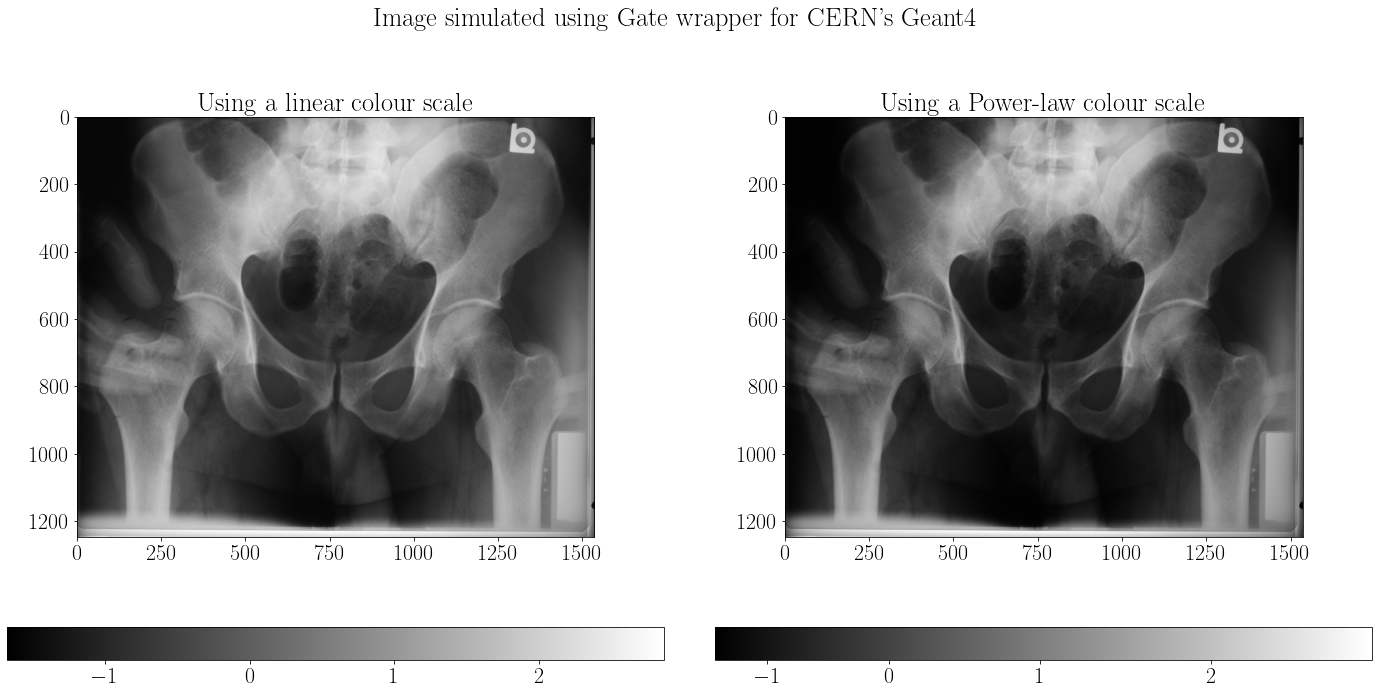

In [50]:
displayLinearPowerScales(ground_truth,
                         "Image simulated using Gate wrapper for CERN's Geant4",
                         "plots/reference_from_Gate-VHP")

## Setting up gVirtualXRay

Before simulating an X-ray image using gVirtualXRay, we must create an OpenGL context.

In [15]:
json2gvxr.initGVXR("notebook-8.json", "OPENGL")

Create an OpenGL context: 800x450
gvxrStatus:	Create window 0
gvxrStatus:	Create window 
0 0 500 500
OpenGL renderer:   NVIDIA GeForce RTX 2080 Ti/PCIe/SSE2
OpenGL version:    3.2.0 NVIDIA 470.42.01
OpenGL vender:     NVIDIA Corporation
Use OpenGL 4.5.
0 0 800 450


## X-ray source

We create an X-ray source. It is a point source.

In [16]:
json2gvxr.initSourceGeometry("notebook-8.json")

Set up the beam
	Source position: [0.0, -50.0, 150.0, 'cm']
	Source shape: PointSource


## Spectrum

The spectrum is polychromatic.

In [17]:
spectrum, unit, k, f = json2gvxr.initSpectrum(verbose=0)
energy_set = sorted(spectrum.keys())

count_set = []

for energy in energy_set:
    count_set.append(spectrum[energy])

Plot the spectrum

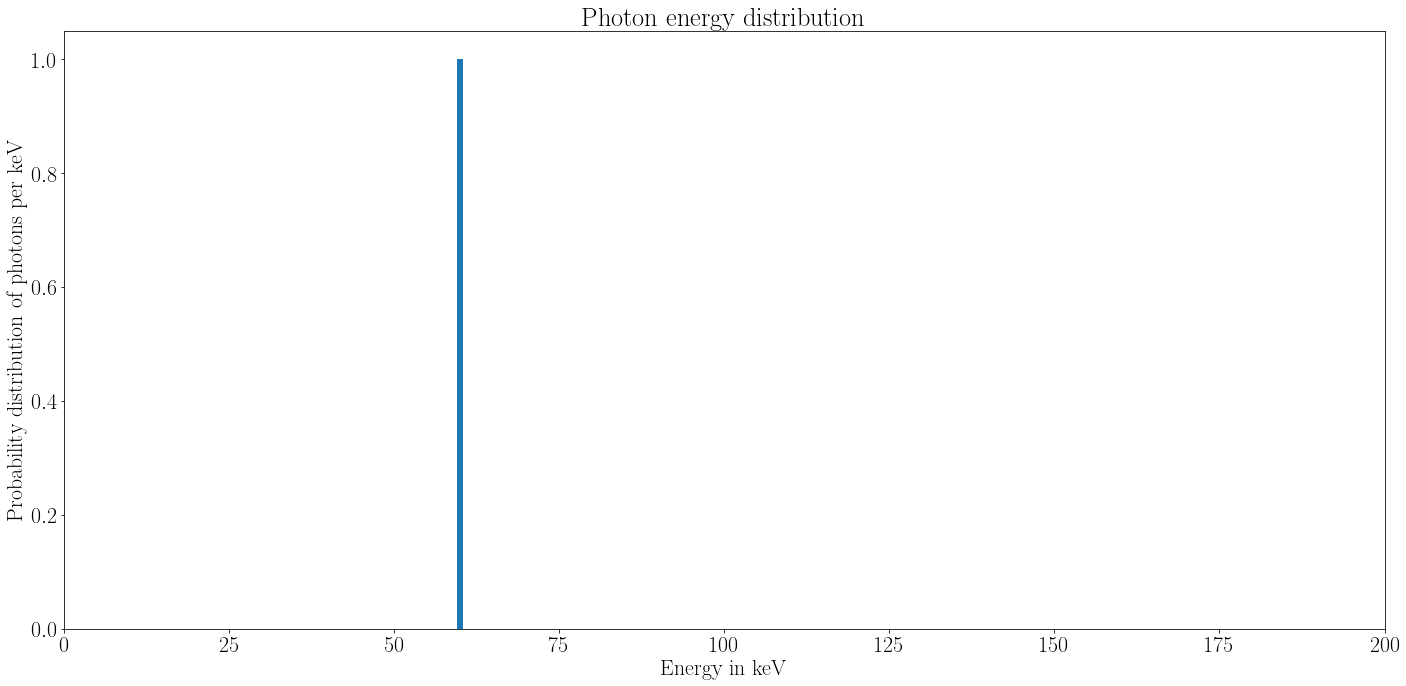

In [18]:
plotSpectrum(k, f, 'plots/spectrum-VHP')

## Detector

Create a digital detector

In [19]:
json2gvxr.initDetector("notebook-8.json")

Set up the detector
	Detector position: [0.0, -50.0, -125.0, 'mm']
	Detector up vector: [0, -1, 0]
	Detector number of pixels: [1536, 1248]
	Energy response: Gate_data/responseDetector.txt in MeV
	Pixel spacing: [0.09765625, 0.09765625, 'mm']
INIT RENDER


## Model the energy response of the detector

Load the energy response

In [20]:
detector_response = np.loadtxt("Gate_data/responseDetector.txt")

Display the energy response

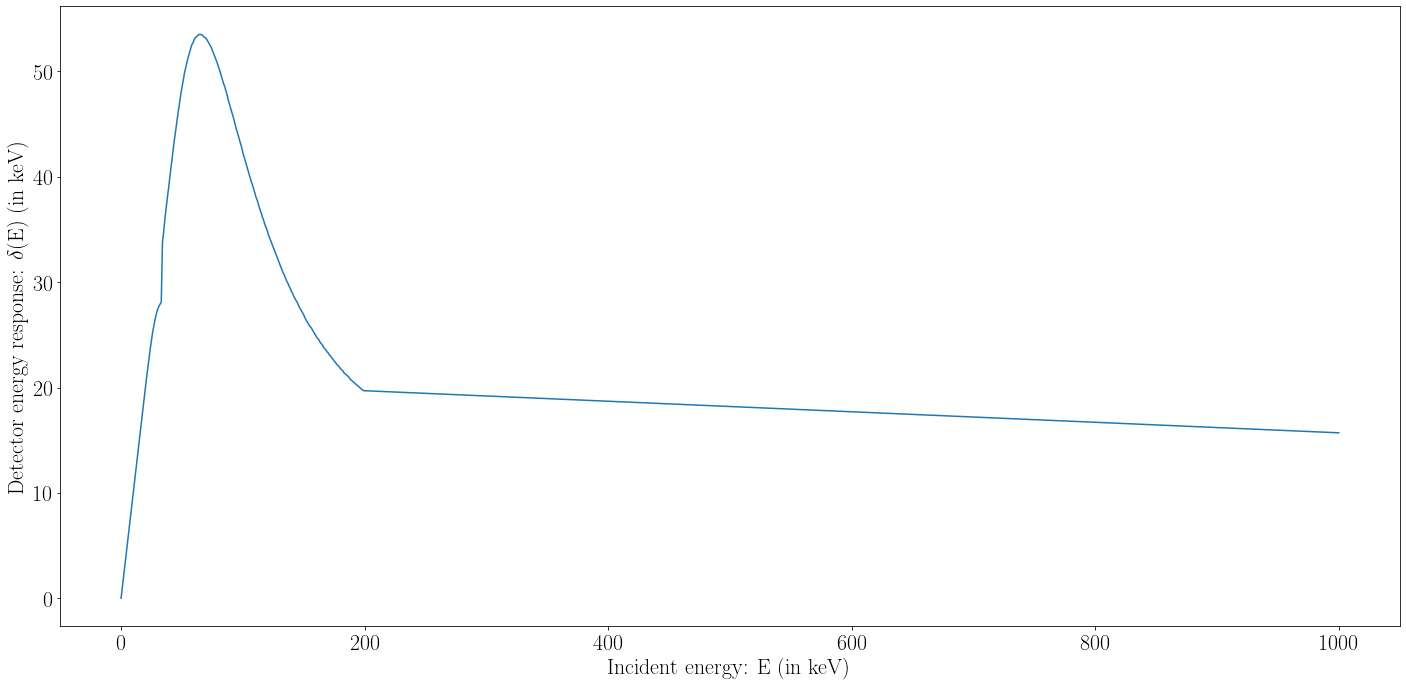

In [21]:
plt.figure(figsize= (20,10))
# plt.title("Detector response")
plt.plot(detector_response[:,0] * 1000, detector_response[:,1] * 1000)
plt.xlabel('Incident energy: E (in keV)')
plt.ylabel('Detector energy response: $\\delta$(E) (in keV)')

plt.tight_layout()

plt.savefig('plots/detector_response-VHP.pdf')
plt.savefig('plots/detector_response-VHP.png')

## Sample

We now load the models segmented from the Visible Human.

Load the samples. `verbose=2` is used to print the material database for Gate. To disable it, use `verbose=0` or `verbose=1`.

In [22]:
json2gvxr.initSamples(verbose=1)

Load the 3D data

	Load rib cage in VHP/meshes/chest.stl using cm
	Loadfile_name:	VHP/meshes/chest.stl	nb_faces:	89235	nb_vertices:	267705	bounding_box (in cm):	(-5.19216, -2.22134, -4.18652)	(5.28961, 12.0778, 3.51821)
 sternum in VHP/meshes/chest2.stl using cm
	Load femurL in VHP/meshes/femurL.stl using cm
file_name:	VHP/meshes/chest2.stl	nb_faces:	75408	nb_vertices:	226224	bounding_box (in cm):	(-5.20763, -2.213, -4.16399)	(5.26581, 12.0682, 4.06685)
file_name:	VHP/meshes/femurL.stl	nb_faces:	9660	nb_vertices:	28980	bounding_box (in cm):	(2.2332, -14.6571, -1.851)	(5.5281, -8.86371, 0.57499)
	Load femurR in VHP/meshes/femurR.stl using cm
	Load hips in VHP/meshes/hips.stl using cm
	Load bladder in VHP/meshes/bladder.stl using cm
	Load bronch in VHP/meshes/bronch.stlfile_name:	VHP/meshes/femurR.stl	nb_faces:	9660	nb_vertices:	28980	bounding_box (in cm):	(-5.60176, -14.6576, -1.48193)	(-2.25352, -8.82717, 0.79766)
file_name:	VHP/meshes/hips.stl	nb_faces:	56575	nb_vertices:	169725	bound

Visualise the virtual patient

## Registration of the patient, source and detector

The SSD, SOD and rotation of the virtual patient are unknown. We estimate them to register a simulated X-ray image on a real radiograph.

In [ ]:
total_energy_in_keV = 0.0
for energy, count in zip(energy_set, count_set):
    effective_energy = find_nearest(detector_response[:,0], energy / 1000, detector_response[:,1])

    total_energy_in_keV += effective_energy * count
    
total_energy_in_MeV = gvxr.getTotalEnergyWithDetectorResponse()

In [ ]:
def objectiveFunction(x):
    
    global total_energy_in_MeV
    
    SOD = x[0]
    SDD = x[1]
    rotation_angle_x = x[2]
    rotation_angle_y = x[3]
    shift = x[4]
    scale = x[5]
    
    
    x_ray_image = np.array(gvxr.computeXRayImage())

    # Flat-field
    x_ray_image /= total_energy_in_MeV
    
    # Brightness/contrast
    x_ray_image += shift
    x_ray_image *= scale
    
    # Negative
    # x_ray_image = 1.0 - x_ray_image
    x_ray_image = np.ones(x_ray_image.shape) - x_ray_image
   
    return np.sum(np.abs(ground_truth - x_ray_image))

## Runing the simulation

Update the 3D visualisation and take a screenshot

In [23]:
gvxr.displayScene()
gvxr.enableArtefactFilteringOnGPU()
gvxr.computeXRayImage()

gvxr.useLighing()
gvxr.useWireframe()
gvxr.setZoom(419.6787109375)
gvxr.setSceneRotationMatrix([ 0.46270546317100525, -0.04590693116188049, -0.8853222727775574,  0.0,
                             -0.0284021757543087,   0.9973739981651306,  -0.06656108051538467, 0.0,
                              0.8860555291175842,   0.055943090468645096, 0.46018826961517334, 0.0,
                              0.0,                  0.0,                  0.0,                 1.0])

gvxr.useNegative()
gvxr.displayScene()

0 0 500 500
0 0 800 450


In [24]:
screenshot = gvxr.takeScreenshot()

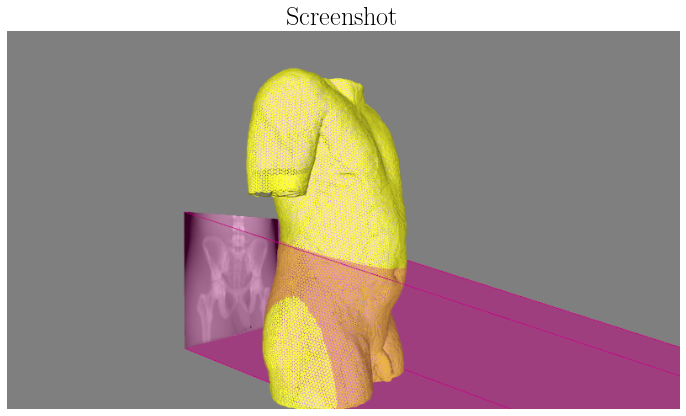

In [18]:
plt.figure(figsize= (10,10))
plt.title("Screenshot")
plt.imshow(screenshot)
plt.axis('off')

plt.tight_layout()

plt.savefig('plots/screenshot-beam-off-VHP.pdf')
plt.savefig('plots/screenshot-beam-off-VHP.png')

Compute an X-ray image

In [19]:
# gvxr.enableArtefactFilteringOnCPU()
gvxr.enableArtefactFilteringOnGPU()
# gvxr.disableArtefactFiltering() # Spere inserts are missing with GPU integration when a outer surface is used for the matrix

In [20]:
# Compute the L-buffers on the GPU and integrate on the CPU
x_ray_image_integration_CPU = computeXRayImageFromLBuffers(json2gvxr, True, detector_response)
imsave('gVirtualXRay_output_data/projection_raw_integration_CPU-VHP.tif', x_ray_image_integration_CPU.astype(np.single))

In [21]:
# Compute the L-buffers on the GPU and integrate on the GPU
x_ray_image_integration_GPU = np.array(gvxr.computeXRayImage())
imsave('gVirtualXRay_output_data/projection_raw_integration_GPU-VHP.tif', x_ray_image_integration_GPU.astype(np.single))

Negative of the data

In [22]:
x_ray_image_integration_CPU *= -1
x_ray_image_integration_GPU *= -1

Normalise the data

In [23]:
x_ray_image_integration_CPU = standardisation(x_ray_image_integration_CPU)
x_ray_image_integration_GPU = standardisation(x_ray_image_integration_GPU)

In [24]:
print(ground_truth.mean(), ground_truth.std())
print(x_ray_image_integration_CPU.mean(), x_ray_image_integration_CPU.std())
print(x_ray_image_integration_GPU.mean(), x_ray_image_integration_GPU.std())

-9.275581252744364e-17 1.0000000000000002
2.0875988497225166e-16 0.9999999999999996
-1.4263281913587082e-16 0.9999999999999997


Flip the image

Save the corresponding image

In [25]:
imsave('gVirtualXRay_output_data/projection_corrected_integration_CPU-VHP.tif', x_ray_image_integration_CPU.astype(np.single))
imsave('gVirtualXRay_output_data/projection_corrected_integration_GPU-VHP.tif', x_ray_image_integration_GPU.astype(np.single))

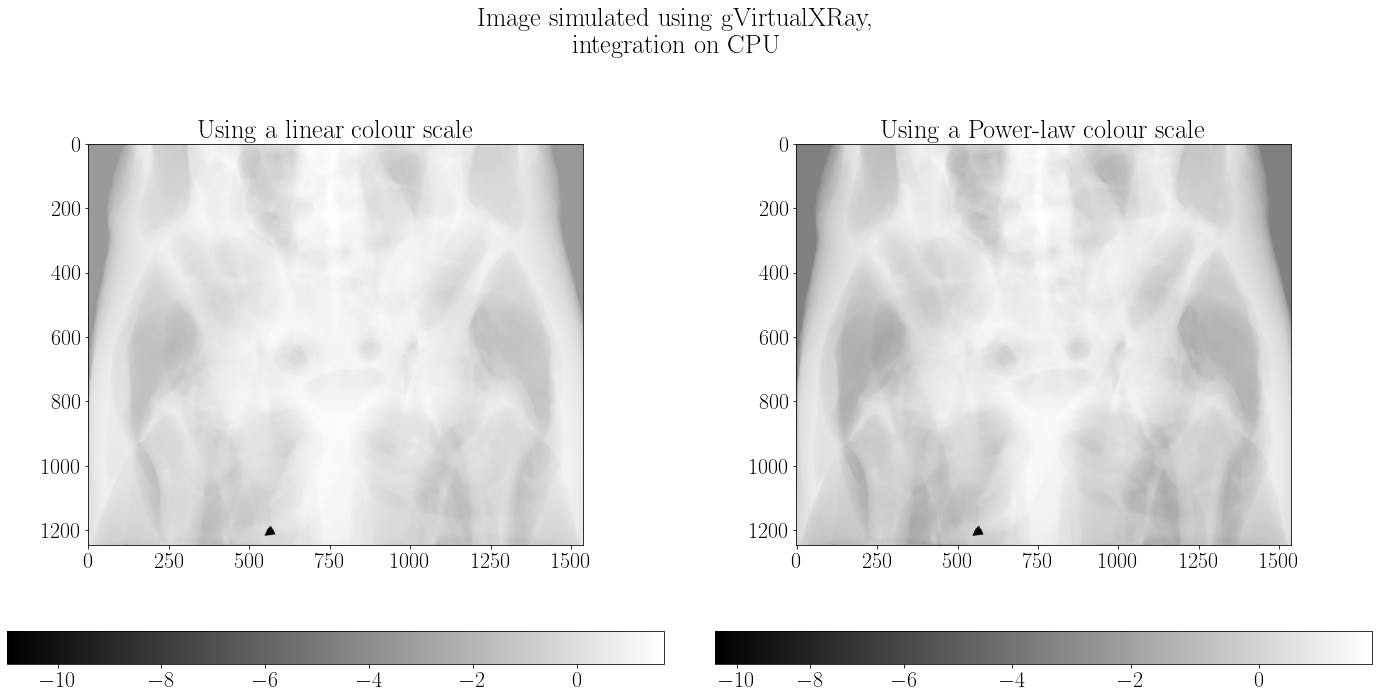

In [26]:
displayLinearPowerScales(x_ray_image_integration_CPU,
                         "Image simulated using gVirtualXRay,\nintegration on CPU",
                         'plots/x_ray_image_integration_CPU-VHP')

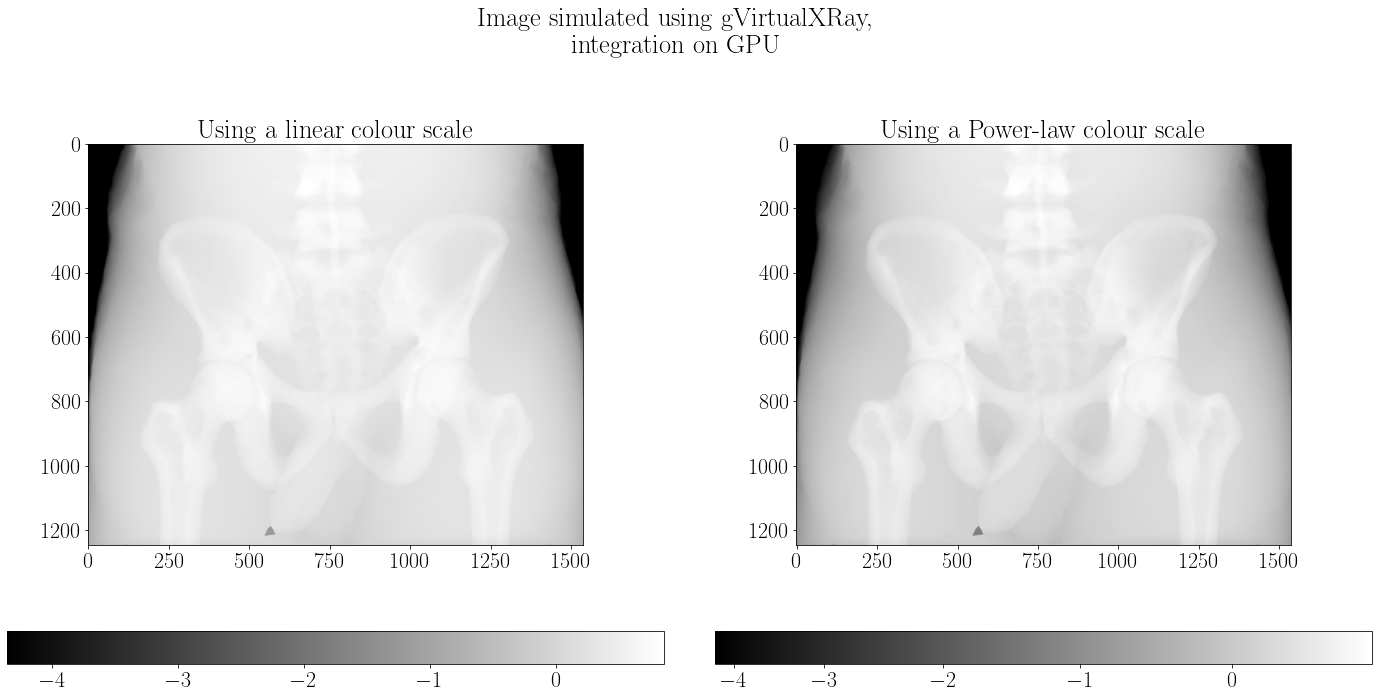

In [27]:
displayLinearPowerScales(x_ray_image_integration_GPU,
                         "Image simulated using gVirtualXRay,\nintegration on GPU",
                         'plots/x_ray_image_integration_GPU-VHP')

Compare the manual implementation with gvxr's

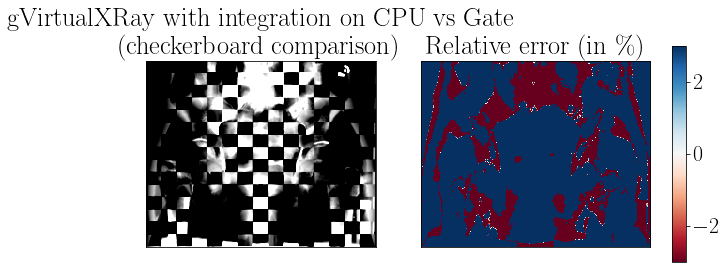

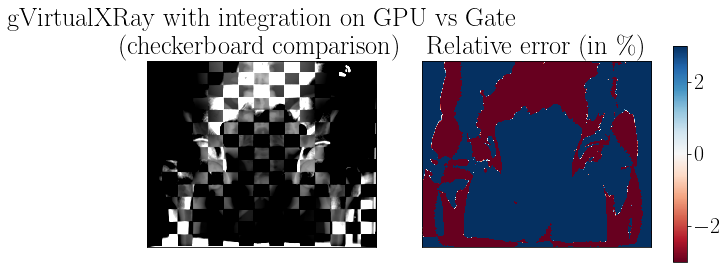

In [28]:
compareImages(x_ray_image_integration_CPU, ground_truth,
              "gVirtualXRay with integration on CPU vs Gate\n(checkerboard comparison)",
              'plots/comparison_integration_CPU-VHP')

compareImages(x_ray_image_integration_GPU, ground_truth,
              "gVirtualXRay with integration on GPU vs Gate\n(checkerboard comparison)",
              'plots/comparison_integration_GPU-VHP')

## Comparison the analytic simulation with the Monte Carlo simulation

### Quantitative validation

Compute image metrics between the two simulated images:

1. [mean absolute percentage error (MAPE)](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error), also known as mean absolute percentage deviation (MAPD),
2. [zero-mean normalised cross-correlation (ZNCC)](https://en.wikipedia.org/wiki/Cross-correlation#Zero-normalized_cross-correlation_(ZNCC)), and
3. [Structural Similarity Index (SSIM)](https://en.wikipedia.org/wiki/Structural_similarity). 


We use these three metrics as one is a disimilarity measurement (MAPE), two are similarity measurement (ZNCC & SSIM). MAPE and ZNCC can be expressed as a percentage, which eases the interpretation of the numerical values. SSIM is a number between 0 and 1. A good value of MAPE s 0%; of ZNCC 100%, and SSIM 1.

In [29]:
MAPE_integration_CPU = mape(ground_truth, x_ray_image_integration_CPU)
ZNCC_integration_CPU = np.mean((ground_truth - ground_truth.mean()) / ground_truth.std() * (x_ray_image_integration_CPU - x_ray_image_integration_CPU.mean()) / x_ray_image_integration_CPU.std())
SSIM_integration_CPU = ssim(ground_truth, x_ray_image_integration_CPU, data_range=ground_truth.max() - ground_truth.min())


print("MAPE_integration_CPU:", "{0:0.2f}".format(100 * MAPE_integration_CPU) + "%")
print("ZNCC_integration_CPU:", "{0:0.2f}".format(100 * ZNCC_integration_CPU) + "%")
print("SSIM_integration_CPU:", "{0:0.2f}".format(SSIM_integration_CPU))

MAPE_integration_GPU = mape(ground_truth, x_ray_image_integration_GPU)
ZNCC_integration_GPU = np.mean((ground_truth - ground_truth.mean()) / ground_truth.std() * (x_ray_image_integration_GPU - x_ray_image_integration_GPU.mean()) / x_ray_image_integration_GPU.std())
SSIM_integration_GPU = ssim(ground_truth, x_ray_image_integration_GPU, data_range=ground_truth.max() - ground_truth.min())

print("MAPE_integration_GPU:", "{0:0.2f}".format(100 * MAPE_integration_GPU) + "%")
print("ZNCC_integration_GPU:", "{0:0.2f}".format(100 * ZNCC_integration_GPU) + "%")
print("SSIM_integration_GPU:", "{0:0.2f}".format(SSIM_integration_GPU))

MAPE_integration_CPU: 1835.89%
ZNCC_integration_CPU: 11.53%
SSIM_integration_CPU: -0.04
MAPE_integration_GPU: 1227.62%
ZNCC_integration_GPU: 30.11%
SSIM_integration_GPU: 0.00


In both cases, MAPE is very small (less than 1%) and ZNCC is very high (more than 99%). We can conclude that the two images are similar. The main difference lie in the Poisson noise affecting the Monte Carlo simulation.

### Qualitative validation

Checkboard comparison

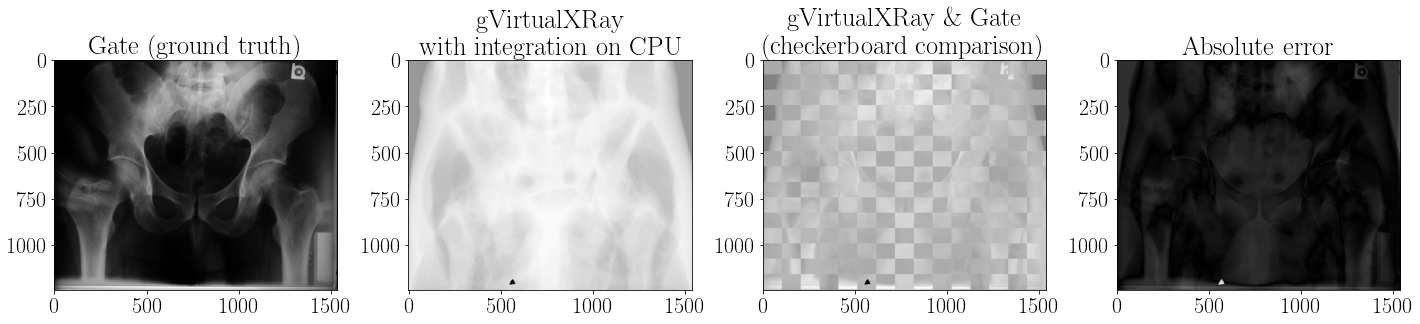

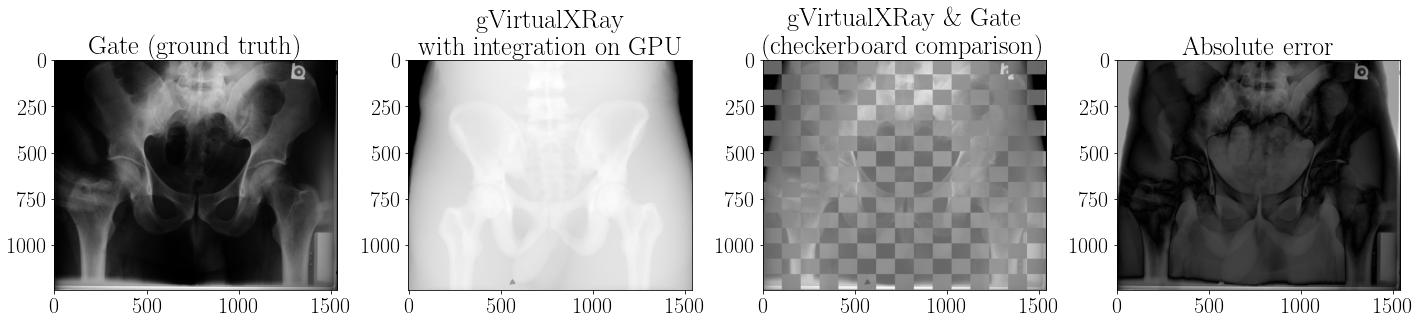

In [30]:
fullCompareImages(ground_truth,
                  x_ray_image_integration_CPU,
                  "gVirtualXRay\n with integration on CPU",
                  "plots/full_comparison_integration_CPU-VHP")

fullCompareImages(ground_truth,
                  x_ray_image_integration_GPU,
                  "gVirtualXRay\n with integration on GPU",
                  "plots/full_comparison_integration_GPU-VHP")

In [31]:
font = {'size'   : 12
       }
matplotlib.rc('font', **font)

Plot the profiles

In [32]:
font = {'size'   : 22
       }
matplotlib.rc('font', **font)

In [33]:
# plotProfiles(json2gvxr, ground_truth, x_ray_image_integration_CPU, x_ray_image_integration_GPU, "plots/profiles-checkerboard-VHP")

In [34]:
# spacing = json2gvxr.params["Detector"]["Size"][0] / json2gvxr.params["Detector"]["NumberOfPixels"][0]
# min_limit = round(40)
# max_limit = round(512 * spacing - 40)
# plotProfiles(json2gvxr, ground_truth, x_ray_image_integration_CPU, x_ray_image_integration_GPU, "plots/profiles-zoom-checkerboard-VHP", [min_limit, max_limit])

## All done

Destroy the window

In [35]:
# gvxr.destroyAllWindows()